# Simple Neural Network learns sine function using JAX, Equinox and Optax

<img src="https://upload.wikimedia.org/wikipedia/commons/8/86/Google_JAX_logo.svg" width=150 />
<img src="https://optax.readthedocs.io/en/latest/_static/logo.svg" width=150 />

In [2]:
### Check which Python your current notebook/kernel uses

import sys
print(sys.executable, sys.version)



c:\Users\mohit\anaconda3\envs\py_latest\python.exe 3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]


In [ ]:
## Create a new Conda env with the latest stable Python (example uses 3.12 — change to python=3.11 if you prefer):

#conda create -n py_latest python=3.12 -y

In [ ]:
## Activate it (you may need conda init powershell and restart the shell the first time):

#conda activate py_latest

In [ ]:
## Upgrade pip and install the kernel package (and Jupyter if you want the notebook server in that env):

# pip install --upgrade pip
# pip install ipykernel jupyter

In [3]:
import sys
print(sys.executable)
print(sys.version)

c:\Users\mohit\anaconda3\envs\py_latest\python.exe
3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]


In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import List

In [5]:
N_SAMPLES = 200
LAYERS = [1, 10, 10, 10, 1]
LEARNING_RATE = 0.1
N_EPOCHS = 30_000

In [6]:
##this step is the dataset generation

key = jax.random.PRNGKey(0)

## creates a JAX pseudo-random number generator (PRNG) key seeded with integer 0.
## The returned key is a small jnp.ndarray (dtype uint32, shape (2,)) that JAX's stateless RNG functions consume to produce random values.


### JAX RNGs are stateless and functional: random functions do not mutate global state. Instead you explicitly pass a PRNG key to random functions and then split the key whenever you need fresh randomness. This makes code deterministic, easier to JIT/VMAP/PMAP, and reproducible.

In [19]:
key, xkey, ynoisekey = jax.random.split(key, 3)
x_samples = jax.random.uniform(xkey, (N_SAMPLES, 1), minval=0.0, maxval=2*jnp.pi)
y_samples = jnp.sin(x_samples) + jax.random.normal(ynoisekey, (N_SAMPLES, 1)) * 0.3

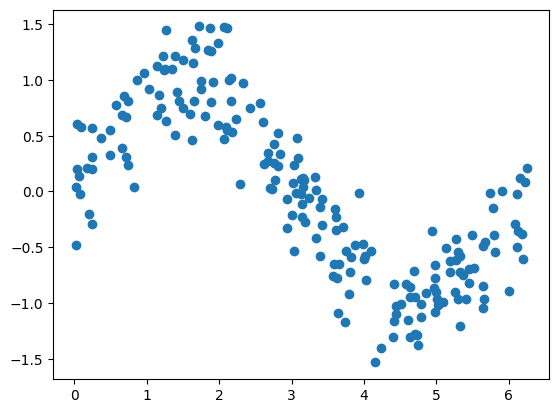

In [20]:
plt.scatter(x_samples, y_samples)

## Implement the neural network architecture

In [ ]:
class SimpleMLP(eqx.Module):
    layers: List[eqx.nn.Linear]

    def __init__(self, layer_sizes, key):
        self.layers = []

        for (fan_in, fan_out) in zip(layer_sizes[:-1], layer_sizes[1:]):
            key, subkey = jax.random.split(key)
            self.layers.append(
                eqx.nn.Linear(fan_in, fan_out, use_bias=True, key=subkey)
            )
    
    def __call__(self, x):
        a = x
        for layer in self.layers[:-1]:
            a = jax.nn.sigmoid(layer(a))
        a = self.layers[-1](a)

        return a

In [21]:
model = SimpleMLP(LAYERS, key=key)

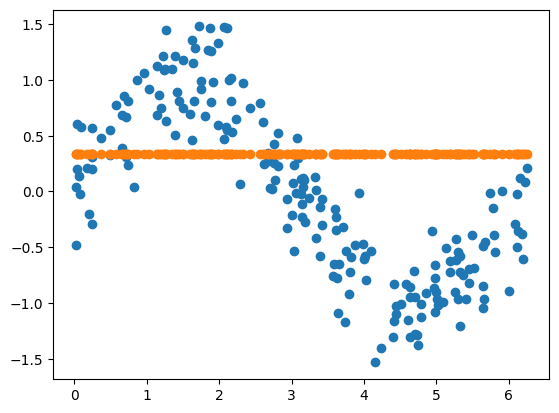

In [22]:
# Initial prediction
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, jax.vmap(model)(x_samples))

In [23]:
## this model would help define the loss metric

def model_to_loss(m, x, y):
    prediction = jax.vmap(m)(x)
    delta = prediction - y
    loss = jnp.mean(delta**2)
    return loss

In [24]:
model_to_loss(model, x_samples, y_samples)

Array(0.71026504, dtype=float32)

In [25]:
model_to_loss_and_grad = eqx.filter_value_and_grad(model_to_loss)

In [26]:
model_to_loss_and_grad(model, x_samples, y_samples)

(Array(0.71026504, dtype=float32),
 SimpleMLP(
   layers=[
     Linear(
       weight=f32[10,1],
       bias=f32[10],
       in_features=1,
       out_features=10,
       use_bias=True
     ),
     Linear(
       weight=f32[10,10],
       bias=f32[10],
       in_features=10,
       out_features=10,
       use_bias=True
     ),
     Linear(
       weight=f32[10,10],
       bias=f32[10],
       in_features=10,
       out_features=10,
       use_bias=True
     ),
     Linear(
       weight=f32[1,10],
       bias=f32[1],
       in_features=10,
       out_features=1,
       use_bias=True
     )
   ]
 ))

In [27]:
opt = optax.sgd(LEARNING_RATE)  # Here you could also use optax.adam(...)
opt_state = opt.init(eqx.filter(model, eqx.is_array))

In [28]:
@eqx.filter_jit
def make_step(m, opt_s, x, y):
    loss, grad = model_to_loss_and_grad(m, x, y)
    updates, opt_s = opt.update(grad, opt_s, m)
    m = eqx.apply_updates(m, updates)
    return m, opt_s, loss

In [29]:
# Training loop
loss_history = []
for epoch in range(N_EPOCHS):
    model, opt_state, loss = make_step(model, opt_state, x_samples, y_samples)
    loss_history.append(loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, loss {loss}")

Epoch 0, loss 0.710265040397644
Epoch 100, loss 0.5726882219314575
Epoch 200, loss 0.5720905065536499
Epoch 300, loss 0.571297287940979
Epoch 400, loss 0.5701445937156677
Epoch 500, loss 0.5683268904685974
Epoch 600, loss 0.5652033090591431
Epoch 700, loss 0.5592589378356934
Epoch 800, loss 0.5463717579841614
Epoch 900, loss 0.5137323141098022
Epoch 1000, loss 0.426095575094223
Epoch 1100, loss 0.29757755994796753
Epoch 1200, loss 0.25289806723594666
Epoch 1300, loss 0.2421375960111618
Epoch 1400, loss 0.23575250804424286
Epoch 1500, loss 0.23012080788612366
Epoch 1600, loss 0.22468861937522888
Epoch 1700, loss 0.2193494588136673
Epoch 1800, loss 0.2141033113002777
Epoch 1900, loss 0.2089824676513672
Epoch 2000, loss 0.20402556657791138
Epoch 2100, loss 0.19926626980304718
Epoch 2200, loss 0.1947285234928131
Epoch 2300, loss 0.19042471051216125
Epoch 2400, loss 0.18635602295398712
Epoch 2500, loss 0.18251346051692963
Epoch 2600, loss 0.17887933552265167
Epoch 2700, loss 0.1754284203052

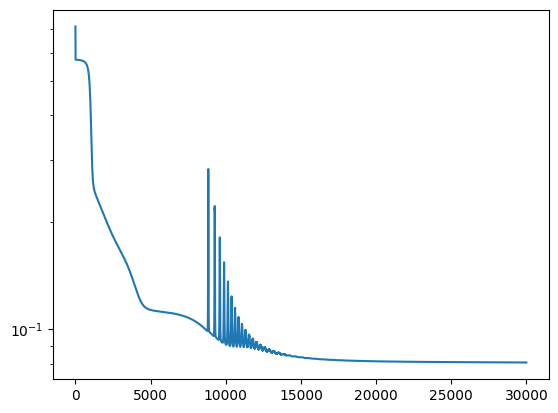

In [30]:
plt.plot(loss_history)
plt.yscale("log")

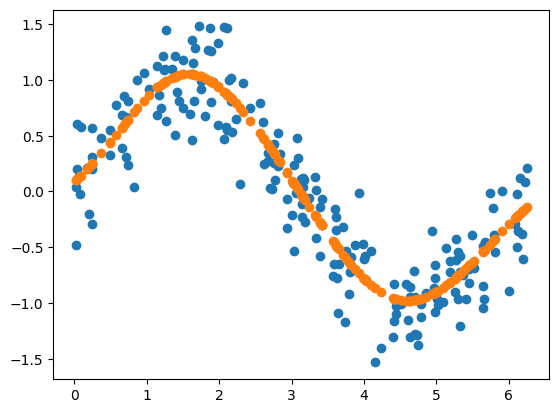

In [31]:
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, jax.vmap(model)(x_samples))